In [1]:
import sys
sys.path.append('Scripts')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets, models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

from utils import path
from utils import createInputFigure

from sklearn import preprocessing
import os
import time
import copy

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
image_size = 224
batch_size = 28
workers = 1
ngpu = 1
validation_split = .2
train_split = 0
shuffle_dataset = True
random_seed = 42
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# device = "cpu"    

In [4]:
def getData(dataType):
    folder = 'RP_Combinados'
#     folder = '0179520170504'
    figPath = path('C:\\Users\\Patrick\\Documents\\GitHub\\ICDeepLearning\\Data\\'+folder+'\\'+dataType)

    dataset = datasets.ImageFolder(root = figPath(),
                                  transform = transforms.Compose([
                                      transforms.Resize(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5),
                                                           (0.5, 0.5, 0.5))
                                  ]))

    class_names = dataset.classes

    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    trainsplit = int(np.floor(train_split * dataset_size))
    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, test_indices = indices[trainsplit:], indices[:trainsplit]
    trainset_size = len(train_indices)
    valsplit = int(np.floor(validation_split * trainset_size))
    train_indices, val_indices = train_indices[valsplit:], train_indices[:valsplit]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(train_indices)

    train_loader = DataLoader(dataset, batch_size = batch_size,
                                        sampler = train_sampler)
    validation_loader = DataLoader(dataset, batch_size = batch_size,
                                        sampler = valid_sampler)
    test_loader = DataLoader(dataset, batch_size = batch_size,
                                        sampler = test_sampler)


    dataloaders = {"train": train_loader, "val": validation_loader, "test": test_loader}

    dataset_sizes = {"train": len(train_indices),
                     "val": len(val_indices),
                     "test": len(test_indices)}
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,
                                             shuffle = True, num_workers = workers)

    
    return dataloaders, dataset_sizes, dataloader, class_names

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, dataloader, num_epochs = 25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    trainAcc = []
    trainLoss = []
    validAcc = []
    validLoss = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                del(inputs)
                del(labels)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                trainAcc.append(epoch_acc)
                trainLoss.append(epoch_loss)
            else:
                validAcc.append(epoch_acc)
                validLoss.append(epoch_loss)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format( time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, [trainAcc, trainLoss], [validAcc, validLoss]


def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
        model.train(mode = was_training)
        
        
def trainModel(model, modelName, criterion, optimizer, scheduler, dataType, figSize, numEpochs = 10):
#     dataTypes = ['512', '768', 'shifted']
    stats = {
        '512': [],
        '768': [],
        'shifted': []
    }
    
    print("Training stage:{}".format(dataType))
    dataloaders, dataset_sizes, dataloader, _ = getData(dataType)
    model, *stats[dataType] = train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, dataloader, num_epochs = numEpochs)
#     torch.save(model.state_dict(), 'Models\\gadf\\'+modelName+'\\cca'+figSize+"\\model.pth")
#     torch.save(stats, 'Models\\gadf\\'+modelName+'\\cca'+figSize+'\\stats'+dataType+'.pth')
        
    return model, stats

***
Example

In [10]:
model = models.resnet18(pretrained = True)
model.fc = nn.Linear(512, 5)

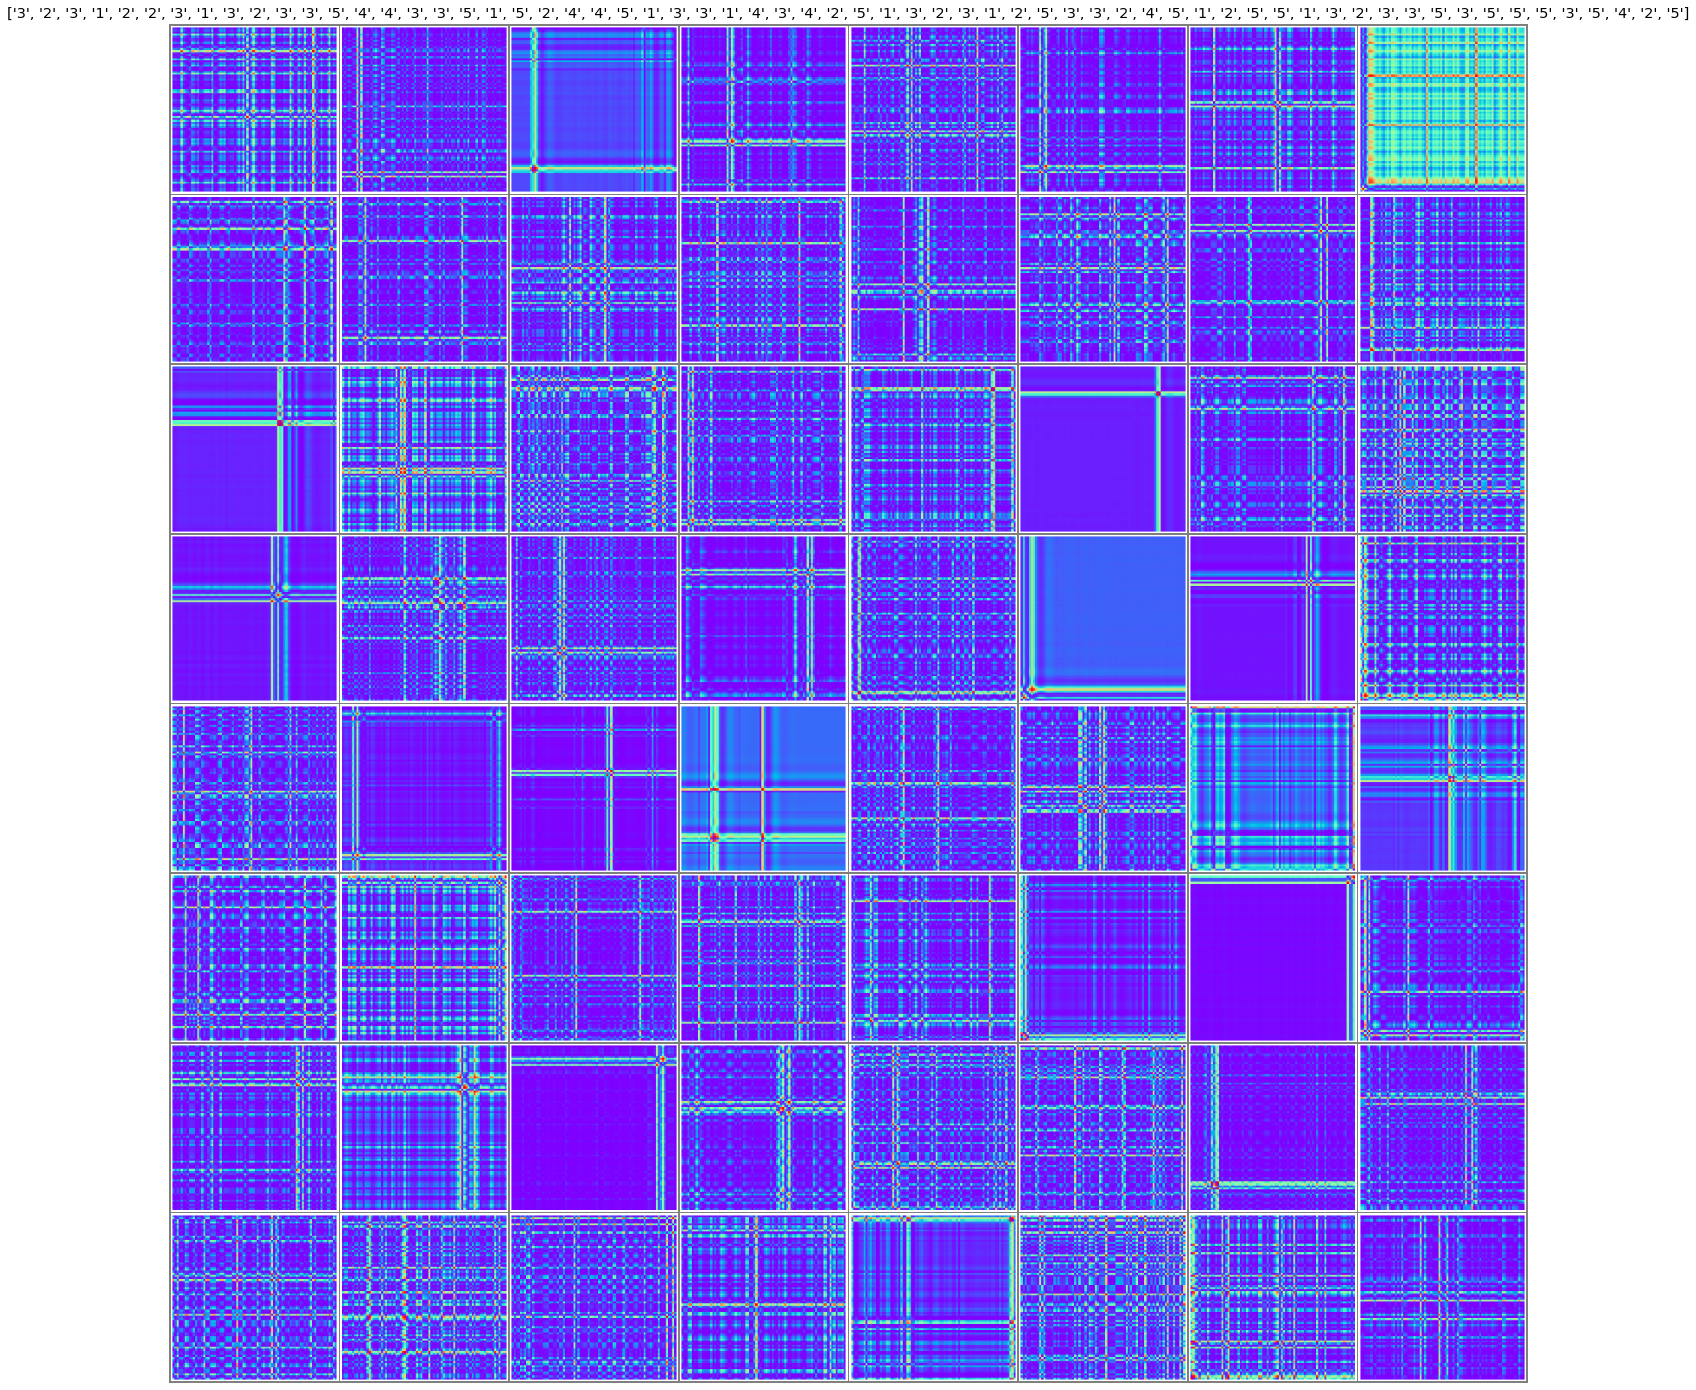

In [8]:
def imshow(inp, title = None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (25, 25))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
# Get a batch of training data
dataloaders, dataset_sizes, dataloader, class_names = getData('512')
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from a batch
out = utils.make_grid(inputs)

imshow(out, title = [class_names[x] for x in classes])

***

In [5]:
modelDict = {
#     'resnet18': [models.resnet18(pretrained = True), 512],
#     'resnet34': [models.resnet34(pretrained = True), 512],
    'resnet50': [models.resnet50(pretrained = True), 2048],
#     'resnet101': [models.resnet101(pretrained = True), 2048],
#     'resnet152': [models.resnet152(pretrained = True), 2048],
#     'densenet121': [models.densenet121(pretrained = True), 1024],
#     'densenet161': [models.densenet161(pretrained = True), 2208],
#     'densenet169': [models.densenet169(pretrained = True), 1664],
#     'densenet201': [models.densenet201(pretrained = True), 1920],
#     'alexnet': [models.alexnet(pretrained = True), 4096],
#     'googlenet': [models.googlenet(pretrained = True), 1024],
#     'vgg11': [models.vgg11(pretrained = True), 4096],
#     'vgg13': [models.vgg13(pretrained = True), 4096],
#     'vgg16': [models.vgg16(pretrained = True), 4096],
#     'vgg19': [models.vgg19(pretrained = True), 4096],
#     'mnasnet0_5': [models.mnasnet0_5(pretrained = True), 1280],
#     'mnasnet1_0': [models.mnasnet1_0(pretrained = True), 1280],
#     'resnext101_32x8d': [models.resnext101_32x8d(pretrained = True), 2048],
#     'resnext50_32x4d': [models.resnext50_32x4d(pretrained = True), 2048],
#     'shufflenet_v2_x0_5': [models.shufflenet_v2_x0_5(pretrained = True), 1024]
}

def lastLayer(modelType, model):
    Dict = {
        'resnet': lambda model: model.fc,
        'densenet': lambda model: model.classifier,
        'alexnet': lambda model: model.classifier[6],
        'vgg': lambda model: model.classifier[6],
        'googlenet': lambda model: model.fc,
        'mnasnet': lambda model: model.classifier[1],
        'resnext': lambda model: model.fc,
        'shufflenet': lambda model: model.fc
    }
    return Dict[modelType](model)

def autoTraining(modelType, modelSize, dataType, figSize, numEpochs):
    modelName = modelType+modelSize
    numClasses = 5
    model = modelDict[modelName][0]
    numFeatures = modelDict[modelName][1]
    classifier = lastLayer(modelType, model)
    classifier = nn.Linear(numFeatures, numClasses)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.3)
#     optimizer = optim.Adam(model.parameters(), lr = 0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)
    model, stats = trainModel(model, modelName, criterion, optimizer, scheduler, dataType, figSize, numEpochs)
    del(model)
    torch.cuda.empty_cache()

In [6]:
modelType = 'resnet'
modelSize = '50'
dataType = '512'
figSize = '128'

model = autoTraining(modelType, modelSize, dataType, figSize, 25)

Training stage:512
Epoch 0/24
----------
train Loss: 1.8909 Acc: 0.3810
val Loss: 1.3023 Acc: 0.4817

Epoch 1/24
----------
train Loss: 0.5467 Acc: 0.8150
val Loss: 0.9750 Acc: 0.6502

Epoch 2/24
----------
train Loss: 0.1383 Acc: 0.9625
val Loss: 0.5783 Acc: 0.8150

Epoch 3/24
----------
train Loss: 0.0295 Acc: 0.9950
val Loss: 0.4924 Acc: 0.8407

Epoch 4/24
----------
train Loss: 0.0079 Acc: 1.0000
val Loss: 0.4187 Acc: 0.8718

Epoch 5/24
----------
train Loss: 0.0042 Acc: 1.0000
val Loss: 0.4071 Acc: 0.8718

Epoch 6/24
----------
train Loss: 0.0041 Acc: 0.9995
val Loss: 0.4202 Acc: 0.8700

Epoch 7/24
----------
train Loss: 0.0032 Acc: 1.0000
val Loss: 0.4364 Acc: 0.8681

Epoch 8/24
----------
train Loss: 0.0026 Acc: 1.0000
val Loss: 0.4327 Acc: 0.8736

Epoch 9/24
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.4123 Acc: 0.8681

Epoch 10/24
----------
train Loss: 0.0015 Acc: 1.0000
val Loss: 0.4047 Acc: 0.8718

Epoch 11/24
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.4

***

In [76]:
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
from skorch.dataset import CVSplit

In [155]:
from sklearn.model_selection import KFold

In [6]:
# folder = 'GAF_Combinados'
dataType = '512'
figsize = '128'
folder = '0179520170504'
figPath = path('C:\\Users\\Patrick\\Documents\\GitHub\\ICDeepLearning\\Data\\'+folder+'\\'+dataType)

dataset = datasets.ImageFolder(root = figPath(),
                              transform = transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5),
                                                   (0.5, 0.5, 0.5))
                            ]))

In [214]:
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, figPath):
        self.transform = transforms.Compose([transforms.Resize(image_size),
                                             transforms.ToTensor(),
                                             transforms.Normalize((0.5, 0.5, 0.5),
                                                                  (0.5, 0.5, 0.5))])
        
        X, y = self.dataLoading(figPath)
        self.X = X
        self.y = y
        
        assert len(X) == len(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.load_image(self.X[i][0]), self.y[i]
    
    def load_image(self, filename):
        image = self.transform(Image.open(filename).convert('RGB'))
#         return Image.open(filename).convert('RGB')
        return image
    
    def dataLoading(self, figPath):
        X = []
        y = []
        for i in range(1, 6):
            path = figPath+'\\'+str(i)
            files = os.listdir(path)
            for picture in files:
                filePath = path + '\\' + picture
                X.append((filePath, i - 1))
                y.append(i - 1)
                
        return X, y

In [215]:
dataset = CustomDataset(figPath)

In [73]:
class PretrainedModel(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.resnet18(pretrained = True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 5)
        self.model = model
        
    def forward(self, x):
        return self.model(x)

In [130]:
# model = NeuralNetClassifier(
#     PretrainedModel,
#     criterion = nn.CrossEntropyLoss,
#     lr = 0.001,
#     batch_size = 4,
#     max_epochs = 5,
#     optimizer = optim.SGD,
#     optimizer__momentum = 0.9,
#     train_split = CVSplit(3),
#     device = 'cuda'
# )

In [211]:
# CALLBACKS
from skorch.callbacks import LRScheduler
from skorch.callbacks import Checkpoint
from skorch.callbacks import Freezer

lrscheduler = LRScheduler(policy = 'StepLR', step_size = 7, gamma = 0.1)
checkpoint = Checkpoint(f_params = 'best_mode.pt', monitor = 'valid_acc_best')
freezer = Freezer(lambda x: not x.startswith('model.fc'))


In [212]:
net = NeuralNetClassifier(
    PretrainedModel,
    criterion = nn.CrossEntropyLoss,
    lr = 0.001,
    batch_size = 4,
    max_epochs = 25,
    module__output_features = 2,
    optimizer = optim.SGD,
    optimizer__momentum = 0.9,
    iterator_train__shuffle = True,
    iterator_train__num_workers = 4,
    iterator_valid__num_workers = 4,
    iterator_valid__shuffle = True,
#     train_split = predefined_split(val_ds),
    train_split = CVSplit(5),
    callbacks = [lrscheduler, checkpoint, freezer],
    device = 'cuda'
)

In [217]:
model.fit(dataset, y = None)

Re-initializing module.
Re-initializing optimizer.
  epoch    train_loss      dur
-------  ------------  -------
      1           nan  47.1568


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PretrainedModel(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

In [133]:
from sklearn.model_selection import cross_validate

In [135]:
cv_results = cross_validate(model, dataset, dataset.y, cv = 3)

C:\Users\Patrick\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
IndexError: invalid index to scalar variable.

  FitFailedWarning)
